In [1]:
using Cropbox

WebIO._IJuliaInit()

In [2]:
using CSV
using DataFrames
using DataFramesMeta
using Dates
using Statistics
using Unitful

# 1. Implementation

## 1.1. Data

In [3]:
load_met(station) = begin
    df = CSV.read("./data/ghcnd/$station.csv", DataFrame)
    df = rename(df, "date" => "date (:Date)", "Tavg" => "Tavg (°C)") |> unitfy

    # dropmissing!(df)
end

load_met (generic function with 1 method)

In [4]:
function load_obs(station::Symbol, code::Symbol)
    s   = String(station)
    tag = code === :CE ? "CE" : "K"
    df  = CSV.read(joinpath("data","$(s)_$(tag).csv"), DataFrame)
    rename!(df, "bloom_doy" => "doy") |> unitfy
    rename!(df, Dict(n => Symbol(n) for n in names(df)))

end

load_obs (generic function with 1 method)

## 1.2. Model

In [5]:
@system Temperature begin
    calendar(context)      ~ ::Calendar
    date(calendar.date)    ~ track::date

    data                   ~ provide(parameter, index = :date, init = date)
    T: temperature         ~ drive(from = data, by = :Tavg, u"°C")
end


Temperature

## 1.2.1. Chilling-Forcing (CF) Model

In [6]:
@system CF(Temperature, Controller) begin
    Tc: temperature_threshold ~ preserve(parameter, u"°C")
    Rc: chilling_requirement  ~ preserve(parameter, u"K")
    Rf: forcing_requirement   ~ preserve(parameter, u"K")

    y(t = calendar.last): year => Dates.year(t)      ~ preserve::int
    doy(t = date): day_of_year => Dates.dayofyear(t) ~ track::int(u"d")

    Ta(T)                                    ~ track(min = 0, u"°C")
    Δt(context.clock.step)                   ~ preserve(u"d")
    ΔT(Ta, Tc, Δt)         => (Ta - Tc) / Δt ~ track(u"K/d")

    c(ΔT): chilling             ~ track(max = 0, u"K/d")
    C(c):  chilling_accumulated ~ accumulate(when = !d, u"K")

    d(C, Rc):    chilling_done => (C <= Rc) ~ flag

    f(ΔT): forcing              ~ track(min = 0, u"K/d")
    F(f):  forcing_accumulated  ~ accumulate(when = d, u"K")

    match(F, Rf)                       => (F >= Rf) ~ flag
    stop(m = match, s = calendar.stop) => (m || s)  ~ flag
end

CF

## 1.2.2. Days Transferred to Standard Temperature (DTS) Model

In [7]:
@system DTS(Temperature, Controller) begin
    Ts: standard_temperature     ~ preserve(parameter, u"°C")
    Ea: temperature_sensitivity  ~ preserve(parameter, u"kJ/mol")
    Rd: accumulation_requirement ~ preserve(parameter)

    y(t = calendar.last): year => Dates.year(t)      ~ preserve::int
    doy(t = date): day_of_year => Dates.dayofyear(t) ~ track::int(u"d")

    R:       gas_constant                  => u"R" ~ preserve(u"J/K/mol")
    Tk(T):   absolute_temperature                  ~ track(u"K")
    Tsk(Ts): absolute_standard_temperature         ~ track(u"K")

    Δt:                     timestep     => 1                                           ~ preserve(u"d")
    ΔT(Tk, Tsk, Ea, R, Δt): rate         => (ℯ^(Ea * (Tk - Tsk) / (R * Tk * Tsk)) / Δt) ~ track(u"d^-1")
    D(ΔT):                  accumulation                                                ~ accumulate

    match(D, Rd)                       => (D >= Rd) ~ flag
    stop(m = match, s = calendar.stop) => (m || s)  ~ flag
end

DTS

## 1.2.3. Growung Degree Days (GDD) Model

In [8]:
@system GDD(Temperature, Controller) begin
    # T:  temperature         ~ preserve(parameter, u"°C")
    # T:  temperature         ~ track(u"°C")
    Tb: base_temperature    ~ preserve(parameter, u"°C")
    To: optimal_temperature ~ preserve(parameter, u"°C")

    Δt(context.clock.step) ~ preserve(u"d")

    GD(T, Tb, To): growing_degree => begin
        max(min(T, To) - Tb, 0u"°C")
    end ~ track(u"K")  

    GDD(GD, Δt): growing_degree_day => begin
        GD / Δt                      
    end ~ track(u"K/d")
    
    cGDD(GDD): cumulative_growing_degree_day ~ accumulate(u"K")
    
    Rg: gdd_requirement ~ preserve(parameter, u"K")
    match(cGDD, Rg) => (cGDD >= Rg) ~ flag
    stop(m = match, s = calendar.stop) => (m || s) ~ flag
end

GDD

## 1.3. Configuration

In [9]:
configure(station, year) = @config (
    :Temperature => (;
        data = @subset(load_met(station), Date(year-1, 10, 1) .<= :date .<= Date(year, 6, 15)),
    ),
    :Calendar => (;
        init = ZonedDateTime(year-1, 10,  1, tz"Asia/Seoul"),
        last = ZonedDateTime(year,    6, 15, tz"Asia/Seoul"),
    ),
    :Clock => (;
        step = 1u"d",
    ),
)

configure (generic function with 1 method)

## 1.4. Estimation

In [10]:
callback(s, m) = if s.stop' && !s.match'
    m.result[end][:doy] = 365u"d"
end

callback (generic function with 1 method)

In [11]:
estimate(S, station, years;
    config,
    index = :year,
    target = :doy,
    stop = :stop,
    kw...
) = simulate(S;
    configs = @config(config + configure.(station, years)),
    index,
    target,
    stop,
    snap = stop,
    callback,
    kw...
)

estimate (generic function with 1 method)

In [12]:
#앙상블 평균

estimate2(Ss, station, years; configs, target = :doy, kw...) = begin
    Es = [estimate(S, station, years; config, target, kw...) for (S, config) in zip(Ss, configs)]
    key = Cropbox.parsetarget(target, nothing) |> only |> first
    M = mean([getproperty(E, key) for E in Es])
    DataFrame([:year => years, key => unitfy(round.(Int, deunitfy(M, u"d")), u"d")])
end

estimate2 (generic function with 1 method)

## 1.5. Evaluation & Visualization

In [13]:
assess(S, obs, station, years; config, kw...) = begin
    est = estimate(S, station, years; config)
    evaluate(obs, est; index = :year, target = :doy, kw...)
end


assess (generic function with 1 method)

In [14]:
assess2(Ss, obs, station, years; configs, kw...) = begin
    est = estimate2(Ss, station, years; configs)
    evaluate(obs, est; index = :year, target = :doy, kw...)
end

assess2 (generic function with 1 method)

In [15]:
compare(S, obs, station, years; config, kw...) = begin
    E = estimate(S, station, years; config)
    O = obs[obs.year .∈ Ref(years), :]
    p = visualize(O, :year, :doy; name = "Obs", kind = :scatterline, kw...)
    visualize!(p, E, :year, :doy; name = "Model", kind = :scatterline)
end

compare (generic function with 1 method)

In [16]:
compare2(Ss, obs, station, years; configs, kw...) = begin
    E = estimate2(Ss, station, years; configs)
    O = obs[obs.year .∈ Ref(years), :]
    p = visualize(O, :year, :doy; name = "Obs", kind = :scatterline, kw...)
    visualize!(p, E, :year, :doy; name = "Model", kind = :scatterline)
end

compare2 (generic function with 1 method)

# 2. Calibration

## 2.1. Naju

In [17]:
met_Naju = load_met(:Naju);

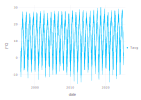

In [18]:
visualize(met_Naju, :date, :Tavg; kind = :line)

In [19]:
years_Naju = vcat(collect(1997), collect(1999:2008), collect(2013), collect(2015:2019))

17-element Vector{Int64}:
 1997
 1999
 2000
 2001
 2002
 2003
 2004
 2005
 2006
 2007
 2008
 2013
 2015
 2016
 2017
 2018
 2019

### 2.1.1. Naju * CE

In [20]:
obs_Naju_CE = load_obs(:Naju, :CE)

Row,location,lat,long,alt,year,cultivar,bloom_date,doy
,String7,Missing,Missing,Missing,Int64,String15,Date,Int64
1,naju,missing,missing,missing,1997,Campbell Early,1997-06-01,152
2,naju,missing,missing,missing,1999,Campbell Early,1999-05-26,146
3,naju,missing,missing,missing,2000,Campbell Early,2000-06-02,154
4,naju,missing,missing,missing,2001,Campbell Early,2001-05-25,145
5,naju,missing,missing,missing,2002,Campbell Early,2002-05-25,145
6,naju,missing,missing,missing,2003,Campbell Early,2003-05-23,143
7,naju,missing,missing,missing,2004,Campbell Early,2004-05-27,148
8,naju,missing,missing,missing,2005,Campbell Early,2005-05-28,148
9,naju,missing,missing,missing,2006,Campbell Early,2006-05-29,149


In [146]:
obs_Naju_CE = DataFrames.select(obs_Naju_CE, [:year, :doy])   # ← DataFrames.select로 확실히

Row,year,doy
,Int64,Int64
1,1997,152
2,1999,146
3,2000,154
4,2001,145
5,2002,145
6,2003,143
7,2004,148
8,2005,148
9,2006,149


In [21]:
obs_Naju_CE.year = Int.(obs_Naju_CE.year)
if !(eltype(obs_Naju_CE.doy) <: Unitful.AbstractQuantity)
    obs_Naju_CE.doy .= Int.(obs_Naju_CE.doy) .* Unitful.u"d"
end

22-element Vector{Quantity{Int64, 𝐓, Unitful.FreeUnits{(d,), 𝐓, nothing}}}:
 152 d
 146 d
 154 d
 145 d
 145 d
 143 d
 148 d
 148 d
 149 d
 153 d
 150 d
 149 d
 143 d
 139 d
 142 d
 134 d
 143 d
 153 d
 139 d
 140 d
 140 d
 145 d

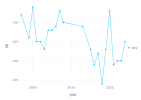

In [22]:
visualize(obs_Naju_CE, :year, :doy; kind = :scatterline)

#### CF

In [23]:
config_cf_Naju_CE = calibrate(CF, obs_Naju_CE;
    configs = configure.(:Naju, years_Naju),
    index = :year,
    target = :doy,
    parameters = :CF => (;
        Tc = (6, 10),
        Rc = (-200, -100),
        Rf = (0, 300),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 855 evals, 775 steps, improv/step: 0.414 (last = 0.4142), fitness=33.000000000
20.00 secs, 1732 evals, 1652 steps, improv/step: 0.379 (last = 0.3478), fitness=32.000000000
30.01 secs, 2591 evals, 2511 steps, improv/step: 0.369 (last = 0.3504), fitness=32.000000000
40.02 secs, 3467 evals, 3387 steps, improv/step: 0.385 (last = 0.4304), fitness=32.000000000
50.03 secs, 4342 evals, 4262 steps, improv/step: 0.417 (last = 0.5429), fitness=32.000000000

Optimization stopped after 5001 steps and 58.37 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 85.67
Function evals per second = 87.01
Improvements/step = 0.43300
Total function evaluations = 5079


Best candidate found: [8.950

Tc,=,8.95042 °C
Rc,=,-119.7 K
Rf,=,282.776 K


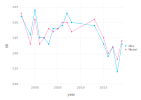

In [24]:
compare(CF, obs_Naju_CE, :Naju, years_Naju;
    config = config_cf_Naju_CE,
    ylim = (130, 155),
)

In [25]:
rmse_Naju_cf_CE = assess(CF, obs_Naju_CE, :Naju, years_Naju;
    config = config_cf_Naju_CE,
    metric = :rmse,
)

2.3514701283890216 d

#### DTS

In [26]:
config_dts_Naju_CE = calibrate(DTS, obs_Naju_CE;
    configs = configure.(:Naju, years_Naju),
    index = :year,
    target = :doy,
    parameters = :DTS => (;
        Ts = (0, 10),
        Ea = (40, 160),
        Rd = (350, 700),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.01 secs, 856 evals, 711 steps, improv/step: 0.241 (last = 0.2405), fitness=57.000000000
20.01 secs, 1749 evals, 1605 steps, improv/step: 0.174 (last = 0.1208), fitness=56.000000000
30.01 secs, 2658 evals, 2514 steps, improv/step: 0.168 (last = 0.1584), fitness=55.000000000
40.02 secs, 3524 evals, 3380 steps, improv/step: 0.161 (last = 0.1409), fitness=55.000000000
50.03 secs, 4399 evals, 4255 steps, improv/step: 0.156 (last = 0.1371), fitness=55.000000000

Optimization stopped after 5001 steps and 58.79 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 85.06
Function evals per second = 87.51
Improvements/step = 0.16320
Total function evaluations = 5145


Best candidate found: [5.872

Ts,=,5.87223 °C
Ea,=,137.011 kJ mol^-1
Rd,=,589.947


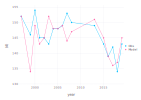

In [27]:
compare(DTS, obs_Naju_CE, :Naju, years_Naju;
    config = config_dts_Naju_CE,
    ylim = (130, 155),
)

In [28]:
rmse_Naju_dts_CE = assess(DTS, obs_Naju_CE, :Naju, years_Naju;
    config = config_dts_Naju_CE,
    metric = :rmse,
)

4.856772106463062 d

#### GDD

In [147]:
config_gdd_Naju_CE = calibrate(GDD, obs_Naju_CE;
    configs = configure.(:Naju, years_Naju),
    index   = :year,
    target  = :doy,
    parameters = :GDD => (;
        Tb = (2, 8),
        To = (1.0e6u"°C", 1.0e6u"°C"),
        Rg = (0, 820),
    ),
    snap = :stop, 
    stop = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2527 evals, 2521 steps, improv/step: 0.979 (last = 0.9786), fitness=Inf

Optimization stopped after 5001 steps and 19.83 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 252.19
Function evals per second = 251.99
Improvements/step = 0.98740
Total function evaluations = 4997


Best candidate found: [4.57111, 1.0e6, 620.535]

Fitness: Inf



Tb,=,4.57111 °C
To,=,1.0e6 °C
Rg,=,620.535 K


In [148]:
compare(GDD, obs_Naju_CE, :Naju, years_Naju;
    config = config_gdd_Naju_CE,
    ylim = (130, 155),
)

LoadError: ArgumentError: column name "year" not found in the data frame since it has no columns

In [149]:
@show typeof(obs_Naju_CE) size(obs_Naju_CE) names(obs_Naju_CE)

# 이상하면 재생성
obs_Naju_CE = select(load_obs(:Naju, :CE), :year, :doy)
met_Naju    = load_met(:Naju)
yrs_weather = unique(year.(met_Naju.date))
obs_Naju_CE = semijoin(obs_Naju_CE, DataFrame(year = yrs_weather), on=:year)

@assert names(obs_Naju_CE) == [:year, :doy] "obs_Naju_CE 컬럼 확인"
@assert nrow(obs_Naju_CE) > 0 "관측×기상 교집합 연도가 없습니다"

years_Naju = collect(obs_Naju_CE.year)

# 이제 OK
compare(GDD, obs_Naju_CE, :Naju, years_Naju; config=config_gdd_Naju_CE, ylim=(130,155))


typeof(obs_Naju_CE) = DataFrame
size(obs_Naju_CE) = (22, 2)
names(obs_Naju_CE) = ["year", "doy"]


LoadError: AssertionError: obs_Naju_CE 컬럼 확인

In [128]:
rmse_Naju_gdd_CE = assess(GDD, obs_Naju_CE, :Naju, years_Naju;
    config = config_gdd_Naju_CE,
    metric = :rmse,
)

NaN

#### Ensemble

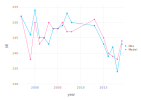

In [32]:
compare2([CF, DTS], obs_Naju_CE, :Naju, years_Naju;
    configs = [config_cf_Naju_CE, config_dts_Naju_CE],
    ylim = (130, 155),
)
     

In [33]:
rmse_Naju_ens_CE = assess2([CF, DTS], obs_Naju_CE, :Naju, years_Naju;
    configs = [config_cf_Naju_CE, config_dts_Naju_CE],
    metric = :rmse,
)

3.547990317647111 d

### 2.1.2. Naju * K

In [34]:
obs_Naju_K  = load_obs(:Naju, :K)

Row,location,lat,long,alt,year,cultivar,bloom_date,doy
,String7,Missing,Missing,Missing,Int64,String7,Date,Int64
1,naju,missing,missing,missing,1999,Kyoho,1999-06-04,155
2,naju,missing,missing,missing,2000,Kyoho,2000-06-03,155
3,naju,missing,missing,missing,2001,Kyoho,2001-05-28,148
4,naju,missing,missing,missing,2002,Kyoho,2002-05-29,149
5,naju,missing,missing,missing,2003,Kyoho,2003-05-28,148
6,naju,missing,missing,missing,2005,Kyoho,2005-06-02,153
7,naju,missing,missing,missing,2006,Kyoho,2006-06-01,152
8,naju,missing,missing,missing,2007,Kyoho,2007-06-03,154
9,naju,missing,missing,missing,2008,Kyoho,2008-05-30,151


In [35]:
years_Naju_K = vcat(collect(1999:2003), collect(2005:2008), collect(2015:2019))

14-element Vector{Int64}:
 1999
 2000
 2001
 2002
 2003
 2005
 2006
 2007
 2008
 2015
 2016
 2017
 2018
 2019

In [36]:
obs_Naju_K.year = Int.(obs_Naju_K.year)
if !(eltype(obs_Naju_K.doy) <: Unitful.AbstractQuantity)
    obs_Naju_K.doy .= Int.(obs_Naju_K.doy) .* Unitful.u"d"
end

19-element Vector{Quantity{Int64, 𝐓, Unitful.FreeUnits{(d,), 𝐓, nothing}}}:
 155 d
 155 d
 148 d
 149 d
 148 d
 153 d
 152 d
 154 d
 151 d
 146 d
 147 d
 146 d
 140 d
 146 d
 157 d
 152 d
 148 d
 142 d
 150 d

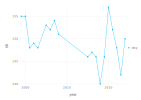

In [37]:
visualize(obs_Naju_K, :year, :doy; kind = :scatterline)

#### CF

In [38]:
config_cf_Naju_K = calibrate(CF, obs_Naju_K;
    configs = configure.(:Naju, years_Naju_K),
    index = :year,
    target = :doy,
    parameters = :CF => (;
        Tc = (0, 10),
        Rc = (-300, -100),
        Rf = (0, 400),
    ),
    stop = :stop,
    snap = :stop,
    callback
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 1254 evals, 1159 steps, improv/step: 0.376 (last = 0.3762), fitness=24.000000000
20.00 secs, 2380 evals, 2285 steps, improv/step: 0.377 (last = 0.3774), fitness=24.000000000
30.02 secs, 3433 evals, 3338 steps, improv/step: 0.440 (last = 0.5783), fitness=24.000000000
40.02 secs, 4434 evals, 4339 steps, improv/step: 0.461 (last = 0.5285), fitness=24.000000000

Optimization stopped after 5001 steps and 46.85 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 106.74
Function evals per second = 108.77
Improvements/step = 0.46980
Total function evaluations = 5096


Best candidate found: [8.00756, -119.403, 377.837]

Fitness: 24.000000000



Tc,=,8.00756 °C
Rc,=,-119.403 K
Rf,=,377.837 K


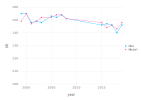

In [39]:
compare(CF, obs_Naju_K, :Naju, years_Naju_K;
    config = config_cf_Naju_K,
    ylim = (100, 160),
)

In [40]:
rmse_Naju_cf_K = assess(CF, obs_Naju_K, :Naju, years_Naju_K;
    config = config_cf_Naju_K,
    metric = :rmse,
)

2.449489742783178 d

#### DTS

In [41]:
config_dts_Naju_K = calibrate(DTS, obs_Naju_K;
    configs = configure.(:Naju, years_Naju_K),
    index = :year,
    target = :doy,
    parameters = :DTS => (;
        Ts = (0, 5),
        Ea = (0, 100),
        Rd = (0, 600),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.01 secs, 1101 evals, 961 steps, improv/step: 0.214 (last = 0.2144), fitness=52.000000000
20.01 secs, 2414 evals, 2272 steps, improv/step: 0.162 (last = 0.1243), fitness=48.000000000
30.01 secs, 4169 evals, 4027 steps, improv/step: 0.159 (last = 0.1538), fitness=45.000000000
40.01 secs, 5128 evals, 4986 steps, improv/step: 0.142 (last = 0.0730), fitness=45.000000000

Optimization stopped after 5001 steps and 40.21 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 124.39
Function evals per second = 127.92
Improvements/step = 0.14180
Total function evaluations = 5143


Best candidate found: [1.78053, 7.7923, 253.204]

Fitness: 45.000000000



Ts,=,1.78053 °C
Ea,=,7.7923 kJ mol^-1
Rd,=,253.204


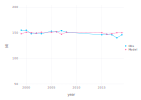

In [42]:
compare(DTS, obs_Naju_K, :Naju, years_Naju_K;
    config = config_dts_Naju_K,
    ylim = (50, 200),
)

In [43]:
rmse_Naju_dts_K = assess(DTS, obs_Naju_K, :Naju, years_Naju_K;
    config = config_dts_Naju_K,
    metric = :rmse,
)

4.367084676466507 d

#### GDD

In [129]:
config_gdd_Naju_K = calibrate(GDD, obs_Naju_K;
    configs = configure.(:Naju, years_Naju),
    index   = :year,
    target  = :doy,
    parameters = :GDD => (;
        Tb = (2, 8),
        To = (1.0e6u"°C", 1.0e6u"°C"),
        Rg = (0, 820),
    ),
    snap = :stop,
    stop = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2691 evals, 2686 steps, improv/step: 0.980 (last = 0.9795), fitness=Inf

Optimization stopped after 5001 steps and 18.75 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 266.72
Function evals per second = 266.51
Improvements/step = 0.98740
Total function evaluations = 4997


Best candidate found: [4.57111, 1.0e6, 620.535]

Fitness: Inf



Tb,=,4.57111 °C
To,=,1.0e6 °C
Rg,=,620.535 K


In [130]:
compare(GDD, obs_Naju_K, :Naju, years_Naju;
    config = config_gdd_Naju_K,
    ylim = (130, 155),
)

LoadError: ArgumentError: column name "year" not found in the data frame since it has no columns

In [131]:
rmse_Naju_gdd_CE = assess(GDD, obs_Naju_K, :Naju, years_Naju;
    config = config_gdd_Naju_K,
    metric = :rmse,
)

NaN

#### Ensemble

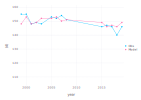

In [47]:
compare2([CF, DTS], obs_Naju_K, :Naju, years_Naju_K;
    configs = [config_cf_Naju_K, config_dts_Naju_K],
    ylim = (105, 160),
)

In [48]:
rmse_Naju_ens_K = assess2([CF, DTS], obs_Naju_K, :Naju, years_Naju_K;
    configs = [config_cf_Naju_K, config_dts_Naju_K],
    metric = :rmse,
)

3.1959796173138706 d

## 2.2. Jinju

In [49]:
met_Jinju = load_met(:Jinju);

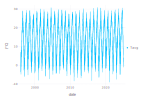

In [50]:
visualize(met_Jinju, :date, :Tavg; kind = :line)

In [51]:
years_Jinju = vcat(collect(1997), collect(1999:2008), collect(2013), collect(2015:2019))

17-element Vector{Int64}:
 1997
 1999
 2000
 2001
 2002
 2003
 2004
 2005
 2006
 2007
 2008
 2013
 2015
 2016
 2017
 2018
 2019

### 2.2.1. Jinju * CE

In [52]:
obs_Jinju_CE = load_obs(:Jinju, :CE)

Row,location,lat,long,alt,year,cultivar,bloom_date,doy
,String7,Missing,Missing,Missing,Int64,String15,Date,Int64
1,jinju,missing,missing,missing,1997,Campbell Early,1997-06-01,152
2,jinju,missing,missing,missing,1998,Campbell Early,1998-05-18,138
3,jinju,missing,missing,missing,1999,Campbell Early,1999-05-26,146
4,jinju,missing,missing,missing,2000,Campbell Early,2000-05-28,149
5,jinju,missing,missing,missing,2001,Campbell Early,2001-05-22,142
6,jinju,missing,missing,missing,2002,Campbell Early,2002-05-13,133
7,jinju,missing,missing,missing,2003,Campbell Early,2003-05-26,146
8,jinju,missing,missing,missing,2004,Campbell Early,2004-05-20,141
9,jinju,missing,missing,missing,2005,Campbell Early,2005-05-16,136


In [53]:
obs_Jinju_CE.year = Int.(obs_Jinju_CE.year)
if !(eltype(obs_Jinju_CE.doy) <: Unitful.AbstractQuantity)
    obs_Jinju_CE.doy .= Int.(obs_Jinju_CE.doy) .* Unitful.u"d"
end

23-element Vector{Quantity{Int64, 𝐓, Unitful.FreeUnits{(d,), 𝐓, nothing}}}:
 152 d
 138 d
 146 d
 149 d
 142 d
 133 d
 146 d
 141 d
 136 d
 155 d
 148 d
 154 d
 143 d
 143 d
 132 d
 134 d
 135 d
 133 d
 142 d
 130 d
 126 d
 131 d
 148 d

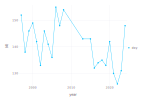

In [54]:
visualize(obs_Jinju_CE, :year, :doy; kind = :scatterline)

#### CF

In [55]:
config_cf_Jinju_CE = calibrate(CF, obs_Jinju_CE;
    configs = configure.(:Jinju, years_Jinju),
    index = :year,
    target = :doy,
    parameters = :CF => (;
        Tc = (6, 8),
        Rc = (-50, 0),
        Rf = (400, 500),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.01 secs, 644 evals, 540 steps, improv/step: 0.309 (last = 0.3093), fitness=80.000000000
20.02 secs, 1224 evals, 1120 steps, improv/step: 0.291 (last = 0.2741), fitness=79.000000000
30.03 secs, 1758 evals, 1654 steps, improv/step: 0.268 (last = 0.2210), fitness=78.000000000
40.04 secs, 2300 evals, 2196 steps, improv/step: 0.248 (last = 0.1845), fitness=78.000000000
50.07 secs, 2808 evals, 2704 steps, improv/step: 0.231 (last = 0.1594), fitness=78.000000000
60.07 secs, 3336 evals, 3232 steps, improv/step: 0.217 (last = 0.1458), fitness=78.000000000
70.07 secs, 3873 evals, 3769 steps, improv/step: 0.222 (last = 0.2495), fitness=78.000000000
80.08 secs, 4413 evals, 4309 steps, improv/step: 0.228 (last = 0.2722), fitne

Tc,=,7.67483 °C
Rc,=,-0.545393 K
Rf,=,442.269 K


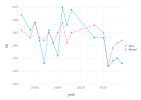

In [56]:
compare(CF, obs_Jinju_CE, :Jinju, years_Jinju;
    config = config_cf_Jinju_CE,
    ylim = (125, 155),
)

In [57]:
rmse_Jinju_cf_CE = assess(CF, obs_Jinju_CE, :Jinju, years_Jinju;
    config = config_cf_Jinju_CE,
    metric = :rmse,
)

5.6672433385927174 d

#### DTS

In [58]:
config_dts_Jinju_CE = calibrate(DTS, obs_Jinju_CE;
    configs = configure.(:Jinju, years_Jinju),
    index = :year,
    target = :doy,
    parameters = :DTS => (;
        Ts = (0, 10),
        Ea = (0, 100),
        Rd = (100, 400),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.02 secs, 501 evals, 368 steps, improv/step: 0.283 (last = 0.2826), fitness=105.000000000
20.03 secs, 989 evals, 839 steps, improv/step: 0.209 (last = 0.1507), fitness=104.000000000
30.04 secs, 1471 evals, 1308 steps, improv/step: 0.164 (last = 0.0832), fitness=104.000000000
40.06 secs, 1925 evals, 1761 steps, improv/step: 0.139 (last = 0.0662), fitness=103.000000000
50.06 secs, 2360 evals, 2196 steps, improv/step: 0.129 (last = 0.0920), fitness=103.000000000
60.06 secs, 2772 evals, 2608 steps, improv/step: 0.122 (last = 0.0801), fitness=102.000000000
70.08 secs, 3172 evals, 3009 steps, improv/step: 0.116 (last = 0.0823), fitness=102.000000000
80.10 secs, 3559 evals, 3396 steps, improv/step: 0.111 (last = 0.0698), 

Ts,=,2.46307 °C
Ea,=,18.3767 kJ mol^-1
Rd,=,273.592


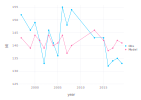

In [59]:
compare(DTS, obs_Jinju_CE, :Jinju, years_Jinju;
    config = config_dts_Jinju_CE,
    ylim = (125, 155),
)

In [60]:
rmse_Jinju_dts_CE = assess(DTS, obs_Jinju_CE, :Jinju, years_Jinju;
    config = config_dts_Jinju_CE,
    metric = :rmse,
)

7.04189145713832 d

#### GDD

In [132]:
config_gdd_Jinju_CE = calibrate(GDD, obs_Jinju_CE;
    configs = configure.(:Jinju, years_Jinju),
    index   = :year,
    target  = :doy,
    parameters = :GDD => (;
        Tb = (2, 8),
        To = (1.0e6u"°C", 1.0e6u"°C"),
        Rg = (0, 820),
    ),
    snap = :stop, 
    stop = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2582 evals, 2577 steps, improv/step: 0.979 (last = 0.9787), fitness=Inf
20.00 secs, 4941 evals, 4945 steps, improv/step: 0.987 (last = 0.9962), fitness=Inf

Optimization stopped after 5001 steps and 20.24 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 247.11
Function evals per second = 246.92
Improvements/step = 0.98740
Total function evaluations = 4997


Best candidate found: [4.57111, 1.0e6, 620.535]

Fitness: Inf



Tb,=,4.57111 °C
To,=,1.0e6 °C
Rg,=,620.535 K


In [133]:
compare(GDD, obs_Jinju_CE, :Jinju, years_Jinju;
    config = config_gdd_Jinju_CE,
    ylim = (130, 155),
)

LoadError: ArgumentError: column name "year" not found in the data frame since it has no columns

In [134]:
rmse_Jinju_gdd_CE = assess(GDD, obs_Jinju_CE, :Jinju, years_Jinju;
    config = config_gdd_Jinju_CE,
    metric = :rmse,
)

NaN

#### Ensemble

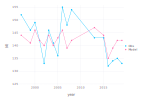

In [64]:
compare2([CF, DTS], obs_Jinju_CE, :Jinju, years_Jinju;
    configs = [config_cf_Jinju_CE, config_dts_Jinju_CE],
    ylim = (125, 155),
)

In [65]:
rmse_Jinju_ens_CE = assess2([CF, DTS], obs_Jinju_CE, :Jinju, years_Jinju;
    configs = [config_cf_Jinju_CE, config_dts_Jinju_CE],
    metric = :rmse,
)

6.361649804515658 d

### 2.2.2. Jinju * K

In [66]:
obs_Jinju_K  = load_obs(:Jinju, :K)

Row,location,lat,long,alt,year,cultivar,bloom_date,doy
,String7,Missing,Missing,Missing,Int64,String7,Date,Int64
1,jinju,missing,missing,missing,1998,Kyoho,1998-05-23,143
2,jinju,missing,missing,missing,1999,Kyoho,1999-06-04,155
3,jinju,missing,missing,missing,2000,Kyoho,2000-06-05,157
4,jinju,missing,missing,missing,2001,Kyoho,2001-06-01,152
5,jinju,missing,missing,missing,2002,Kyoho,2002-06-04,155
6,jinju,missing,missing,missing,2003,Kyoho,2003-06-03,154
7,jinju,missing,missing,missing,2004,Kyoho,2004-06-01,153
8,jinju,missing,missing,missing,2005,Kyoho,2005-05-27,147
9,jinju,missing,missing,missing,2006,Kyoho,2006-06-04,155


In [67]:
years_Jinju_K = vcat(collect(1998:2008), collect(2013), collect(2015:2019))

17-element Vector{Int64}:
 1998
 1999
 2000
 2001
 2002
 2003
 2004
 2005
 2006
 2007
 2008
 2013
 2015
 2016
 2017
 2018
 2019

In [68]:
obs_Jinju_K.year = Int.(obs_Jinju_K.year)
if !(eltype(obs_Jinju_K.doy) <: Unitful.AbstractQuantity)
    obs_Jinju_K.doy .= Int.(obs_Jinju_K.doy) .* Unitful.u"d"
end

22-element Vector{Quantity{Int64, 𝐓, Unitful.FreeUnits{(d,), 𝐓, nothing}}}:
 143 d
 155 d
 157 d
 152 d
 155 d
 154 d
 153 d
 147 d
 155 d
 148 d
 154 d
 149 d
 146 d
 136 d
 135 d
 140 d
 140 d
 146 d
 137 d
 138 d
 135 d
 141 d

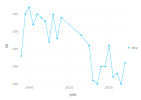

In [69]:
visualize(obs_Jinju_K, :year, :doy; kind = :scatterline)

#### CF

In [70]:
config_cf_Jinju_K = calibrate(CF, obs_Jinju_K;
    configs = configure.(:Jinju, years_Jinju_K),
    index = :year,
    target = :doy,
    parameters = :CF => (;
        Tc = (0, 10),
        Rc = (-200, -50),
        Rf = (0, 400),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 1415 evals, 1335 steps, improv/step: 0.399 (last = 0.3985), fitness=87.000000000
20.00 secs, 2490 evals, 2412 steps, improv/step: 0.344 (last = 0.2758), fitness=87.000000000
30.01 secs, 3514 evals, 3436 steps, improv/step: 0.360 (last = 0.3994), fitness=87.000000000
40.02 secs, 4507 evals, 4431 steps, improv/step: 0.402 (last = 0.5467), fitness=87.000000000

Optimization stopped after 5001 steps and 44.97 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 111.20
Function evals per second = 112.87
Improvements/step = 0.41540
Total function evaluations = 5076


Best candidate found: [9.5894, -50.4586, 372.961]

Fitness: 87.000000000



Tc,=,9.5894 °C
Rc,=,-50.4586 K
Rf,=,372.961 K


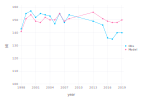

In [71]:
compare(CF, obs_Jinju_K, :Jinju, years_Jinju_K;
    config = config_cf_Jinju_K,
    ylim = (100, 160),
)

In [72]:
rmse_Jinju_cf_K = assess(CF, obs_Jinju_K, :Jinju, years_Jinju_K;
    config = config_cf_Jinju_K,
    metric = :rmse,
)

6.393930945918674 d

#### DTS

In [73]:
config_dts_Jinju_K = calibrate(DTS, obs_Jinju_K;
    configs = configure.(:Jinju, years_Jinju_K),
    index = :year,
    target = :doy,
    parameters = :DTS => (;
        Ts = (0, 10),
        Ea = (0, 100),
        Rd = (0, 300),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 1095 evals, 979 steps, improv/step: 0.251 (last = 0.2513), fitness=95.000000000
20.01 secs, 2410 evals, 2294 steps, improv/step: 0.159 (last = 0.0905), fitness=94.000000000
30.02 secs, 3536 evals, 3420 steps, improv/step: 0.130 (last = 0.0719), fitness=94.000000000
40.02 secs, 4605 evals, 4489 steps, improv/step: 0.115 (last = 0.0655), fitness=94.000000000

Optimization stopped after 5001 steps and 44.48 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 112.44
Function evals per second = 115.05
Improvements/step = 0.11020
Total function evaluations = 5117


Best candidate found: [5.43616, 7.91636, 250.017]

Fitness: 94.000000000



Ts,=,5.43616 °C
Ea,=,7.91636 kJ mol^-1
Rd,=,250.017


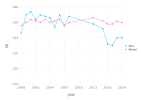

In [74]:
compare(DTS, obs_Jinju_K, :Jinju, years_Jinju_K;
    config = config_dts_Jinju_K,
    ylim = (110, 160),
)

In [75]:
rmse_Jinju_dts_K = assess(DTS, obs_Jinju_K, :Jinju, years_Jinju_K;
    config = config_dts_Jinju_K,
    metric = :rmse,
)

6.782329983125268 d

#### GDD

In [135]:
config_gdd_Jinju_K = calibrate(GDD, obs_Jinju_K;
    configs = configure.(:Jinju, years_Jinju),
    index   = :year,
    target  = :doy,
    parameters = :GDD => (;
        Tb = (2, 8),
        To = (1.0e6u"°C", 1.0e6u"°C"),
        Rg = (0, 820),
    ),
    snap = :stop, 
    stop = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2534 evals, 2528 steps, improv/step: 0.979 (last = 0.9786), fitness=Inf
20.01 secs, 4932 evals, 4935 steps, improv/step: 0.987 (last = 0.9963), fitness=Inf

Optimization stopped after 5001 steps and 20.25 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 246.97
Function evals per second = 246.77
Improvements/step = 0.98740
Total function evaluations = 4997


Best candidate found: [4.57111, 1.0e6, 620.535]

Fitness: Inf



Tb,=,4.57111 °C
To,=,1.0e6 °C
Rg,=,620.535 K


In [136]:
compare(GDD, obs_Jinju_K, :Jinju, years_Jinju;
    config = config_gdd_Jinju_K,
    ylim = (130, 155),
)

LoadError: ArgumentError: column name "year" not found in the data frame since it has no columns

In [137]:
rmse_Jinju_gdd_K = assess(GDD, obs_Jinju_K, :Jinju, years_Jinju;
    config = config_gdd_Jinju_K,
    metric = :rmse,
)

NaN

#### Ensemble

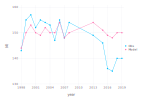

In [79]:
compare2([CF, DTS], obs_Jinju_K, :Jinju, years_Jinju_K;
    configs = [config_cf_Jinju_K, config_dts_Jinju_K],
    ylim = (130, 160),
)

In [80]:
rmse_Jinju_ens_K = assess2([CF, DTS], obs_Jinju_K, :Jinju, years_Jinju;
    configs = [config_cf_Jinju_K, config_dts_Jinju_K],
    metric = :rmse,
)

6.652067347825035 d

## 2.3. Okcheon

In [81]:
met_Okcheon = load_met(:Okcheon);

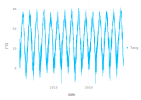

In [82]:
visualize(met_Okcheon, :date, :Tavg; kind = :line)

In [83]:
years_Okcheon = vcat(collect(2013), collect(2015:2019))

6-element Vector{Int64}:
 2013
 2015
 2016
 2017
 2018
 2019

### 2.3.1. Okcheon * CE

In [84]:
obs_Okcheon_CE = load_obs(:Okcheon, :CE)

Row,location,lat,long,alt,year,cultivar,bloom_date,doy
,String7,Missing,Missing,Missing,Int64,String15,Date,Int64
1,okcheon,missing,missing,missing,1997,Campbell Early,1997-06-01,152
2,okcheon,missing,missing,missing,1998,Campbell Early,1998-05-25,145
3,okcheon,missing,missing,missing,1999,Campbell Early,1999-05-26,146
4,okcheon,missing,missing,missing,2000,Campbell Early,2000-05-30,151
5,okcheon,missing,missing,missing,2001,Campbell Early,2001-05-20,140
6,okcheon,missing,missing,missing,2002,Campbell Early,2002-05-20,140
7,okcheon,missing,missing,missing,2003,Campbell Early,2003-05-27,147
8,okcheon,missing,missing,missing,2004,Campbell Early,2004-05-25,146
9,okcheon,missing,missing,missing,2005,Campbell Early,2005-05-28,148


In [85]:
obs_Okcheon_CE.year = Int.(obs_Okcheon_CE.year)
if !(eltype(obs_Okcheon_CE.doy) <: Unitful.AbstractQuantity)
    obs_Okcheon_CE.doy .= Int.(obs_Okcheon_CE.doy) .* Unitful.u"d"
end

23-element Vector{Quantity{Int64, 𝐓, Unitful.FreeUnits{(d,), 𝐓, nothing}}}:
 152 d
 145 d
 146 d
 151 d
 140 d
 140 d
 147 d
 146 d
 148 d
 152 d
 152 d
 147 d
 149 d
 144 d
 144 d
 142 d
 139 d
 146 d
 150 d
 148 d
 140 d
 139 d
 135 d

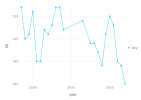

In [86]:
visualize(obs_Okcheon_CE, :year, :doy; kind = :scatterline)

#### CF

In [87]:
config_cf_Okcheon_CE = calibrate(CF, obs_Okcheon_CE;
    configs = configure.(:Okcheon, years_Okcheon),
    index = :year,
    target = :doy,
    parameters = :CF => (;
        Tc = (6, 10),
        Rc = (-200, -100),
        Rf = (0, 300),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.01 secs, 3273 evals, 3192 steps, improv/step: 0.446 (last = 0.4458), fitness=8.000000000

Optimization stopped after 5001 steps and 15.26 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 327.66
Function evals per second = 332.90
Improvements/step = 0.48660
Total function evaluations = 5081


Best candidate found: [9.96761, -184.926, 294.859]

Fitness: 8.000000000



Tc,=,9.96761 °C
Rc,=,-184.926 K
Rf,=,294.859 K


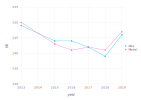

In [88]:
compare(CF, obs_Okcheon_CE, :Okcheon, years_Okcheon;
    config = config_cf_Okcheon_CE,
    ylim = (130, 155),
)

In [89]:
rmse_Okcheon_cf_CE = assess(CF, obs_Okcheon_CE, :Okcheon, years_Okcheon;
    config = config_cf_Okcheon_CE,
    metric = :rmse,
)

1.632993161855452 d

#### DTS

In [90]:
config_dts_Okcheon_CE = calibrate(DTS, obs_Okcheon_CE;
    configs = configure.(:Okcheon, years_Okcheon),
    index = :year,
    target = :doy,
    parameters = :DTS => (;
        Ts = (0, 10),
        Ea = (0, 150),
        Rd = (200, 600),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 3653 evals, 3510 steps, improv/step: 0.109 (last = 0.1085), fitness=12.000000000

Optimization stopped after 5001 steps and 15.08 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 331.54
Function evals per second = 341.02
Improvements/step = 0.10560
Total function evaluations = 5144


Best candidate found: [1.31858, 13.8028, 278.586]

Fitness: 11.000000000



Ts,=,1.31858 °C
Ea,=,13.8028 kJ mol^-1
Rd,=,278.586


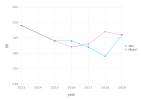

In [91]:
compare(DTS, obs_Okcheon_CE, :Okcheon, years_Okcheon;
    config = config_dts_Okcheon_CE,
    ylim = (130, 155),
)

In [92]:
rmse_Okcheon_dts_CE = assess(DTS, obs_Okcheon_CE, :Okcheon, years_Okcheon;
    config = config_dts_Okcheon_CE,
    metric = :rmse,
)

3.391164991562634 d

#### GDD

In [139]:
config_gdd_Okcheon_CE = calibrate(GDD, obs_Okcheon_CE;
    configs = configure.(:Okcheon, years_Okcheon),
    index   = :year,
    target  = :doy,
    parameters = :GDD => (;
        Tb = (2, 8),
        To = (1.0e6u"°C", 1.0e6u"°C"),
        Rg = (0, 820),
    ),
    snap = :stop, 
    stop = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 7.27 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 688.15
Function evals per second = 687.60
Improvements/step = 0.98740
Total function evaluations = 4997


Best candidate found: [4.57111, 1.0e6, 620.535]

Fitness: Inf



Tb,=,4.57111 °C
To,=,1.0e6 °C
Rg,=,620.535 K


In [140]:
compare(GDD, obs_Okcheon_CE, :Okcheon, years_Okcheon;
    config = config_gdd_Okcheon_CE,
    ylim = (130, 155),
)

LoadError: ArgumentError: column name "year" not found in the data frame since it has no columns

In [141]:
rmse_Okcheon_gdd_CE = assess(GDD, obs_Okcheon_CE, :Okcheon, years_Okcheon;
    config = config_gdd_Okcheon_CE,
    metric = :rmse,
)

NaN

#### Ensemble

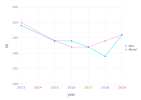

In [96]:
compare2([CF, DTS], obs_Okcheon_CE, :Okcheon, years_Okcheon;
    configs = [config_cf_Okcheon_CE, config_dts_Okcheon_CE],
    ylim = (130, 155),
)

In [97]:
rmse_Okcheon_ens_CE = assess2([CF, DTS], obs_Okcheon_CE, :Okcheon, years_Okcheon;
    configs = [config_cf_Okcheon_CE, config_dts_Okcheon_CE],
    metric = :rmse,
)

2.23606797749979 d

### 2.1.2. Okchoen * K

In [98]:
obs_Okcheon_K  = load_obs(:Okcheon, :K)

Row,location,lat,long,alt,year,cultivar,bloom_date,doy
,String7,Missing,Missing,Missing,Int64,String7,Date,Int64
1,okcheon,missing,missing,missing,1999,Kyoho,1999-06-04,155
2,okcheon,missing,missing,missing,2002,Kyoho,2002-05-30,150
3,okcheon,missing,missing,missing,2003,Kyoho,2003-06-07,158
4,okcheon,missing,missing,missing,2004,Kyoho,2004-06-04,156
5,okcheon,missing,missing,missing,2005,Kyoho,2005-06-05,156
6,okcheon,missing,missing,missing,2006,Kyoho,2006-06-06,157
7,okcheon,missing,missing,missing,2007,Kyoho,2007-06-04,155
8,okcheon,missing,missing,missing,2008,Kyoho,2008-06-03,155
9,okcheon,missing,missing,missing,2013,Kyoho,2013-06-01,152


In [99]:
obs_Okcheon_K.year = Int.(obs_Okcheon_K.year)
if !(eltype(obs_Okcheon_K.doy) <: Unitful.AbstractQuantity)
    obs_Okcheon_K.doy .= Int.(obs_Okcheon_K.doy) .* Unitful.u"d"
end

19-element Vector{Quantity{Int64, 𝐓, Unitful.FreeUnits{(d,), 𝐓, nothing}}}:
 155 d
 150 d
 158 d
 156 d
 156 d
 157 d
 155 d
 155 d
 152 d
 148 d
 148 d
 151 d
 149 d
 147 d
 156 d
 151 d
 147 d
 145 d
 142 d

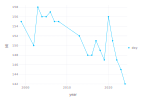

In [100]:
visualize(obs_Okcheon_K, :year, :doy; kind = :scatterline)

#### CF

In [101]:
config_cf_Okcheon_K = calibrate(CF, obs_Okcheon_K;
    configs = configure.(:Okcheon, years_Okcheon),
    index = :year,
    target = :doy,
    parameters = :CF => (;
        Tc = (0, 15),
        Rc = (-250, 100),
        Rf = (0, 500),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2629 evals, 2507 steps, improv/step: 0.266 (last = 0.2665), fitness=8.000000000

Optimization stopped after 5001 steps and 19.31 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 259.04
Function evals per second = 265.36
Improvements/step = 0.33420
Total function evaluations = 5123


Best candidate found: [13.4007, -181.83, 162.755]

Fitness: 8.000000000



Tc,=,13.4007 °C
Rc,=,-181.83 K
Rf,=,162.755 K


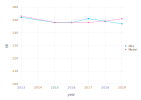

In [102]:
compare(CF, obs_Okcheon_K, :Okcheon, years_Okcheon;
    config = config_cf_Okcheon_K,
    ylim = (100, 160),
)

In [103]:
rmse_Okcheon_cf_K = assess(CF, obs_Okcheon_K, :Okcheon, years_Okcheon;
    config = config_cf_Okcheon_K,
    metric = :rmse,
)

2.0816659994661326 d

#### DTS

In [104]:
config_dts_Okcheon_K = calibrate(DTS, obs_Okcheon_K;
    configs = configure.(:Okcheon, years_Okcheon),
    index = :year,
    target = :doy,
    parameters = :DTS => (;
        Ts = (0, 10),
        Ea = (0, 50),
        Rd = (0, 300),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 2714 evals, 2580 steps, improv/step: 0.197 (last = 0.1973), fitness=7.000000000

Optimization stopped after 5001 steps and 18.93 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 264.20
Function evals per second = 271.17
Improvements/step = 0.16940
Total function evaluations = 5133


Best candidate found: [3.56844, 2.94134, 245.043]

Fitness: 7.000000000



Ts,=,3.56844 °C
Ea,=,2.94134 kJ mol^-1
Rd,=,245.043


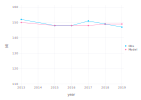

In [105]:
compare(DTS, obs_Okcheon_K, :Okcheon, years_Okcheon;
    config = config_dts_Okcheon_K,
    ylim = (110, 160),
)

In [106]:
rmse_Okcheon_dts_K = assess(DTS, obs_Okcheon_K, :Okcheon, years_Okcheon;
    config = config_dts_Okcheon_K,
    metric = :rmse,
)

1.6832508230603465 d

#### GDD

In [142]:
config_gdd_Okcheon_K = calibrate(GDD, obs_Okcheon_K;
    configs = configure.(:Okcheon, years_Okcheon),
    index   = :year,
    target  = :doy,
    parameters = :GDD => (;
        Tb = (2, 8),
        To = (1.0e6u"°C", 1.0e6u"°C"),
        Rg = (0, 820),
    ),
    snap = :stop, 
    stop = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 7.36 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 679.84
Function evals per second = 679.29
Improvements/step = 0.98740
Total function evaluations = 4997


Best candidate found: [4.57111, 1.0e6, 620.535]

Fitness: Inf



Tb,=,4.57111 °C
To,=,1.0e6 °C
Rg,=,620.535 K


In [143]:
compare(GDD, obs_Okcheon_K, :Okcheon, years_Okcheon;
    config = config_gdd_Okcheon_K,
    ylim = (130, 155),
)

LoadError: ArgumentError: column name "year" not found in the data frame since it has no columns

In [144]:
rmse_Okcheon_gdd_K = assess(GDD, obs_Okcheon_K, :Okcheon, years_Okcheon;
    config = config_gdd_Okcheon_K,
    metric = :rmse,
)

NaN

#### Ensemble

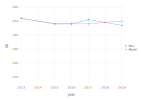

In [110]:
compare2([CF, DTS], obs_Okcheon_K, :Okcheon, years_Okcheon;
    configs = [config_cf_Okcheon_K, config_dts_Okcheon_K],
    ylim = (105, 160),
)

In [111]:
rmse_Okcheon_ens_K = assess2([CF, DTS], obs_Okcheon_K, :Okcheon, years_Okcheon;
    configs = [config_cf_Okcheon_K, config_dts_Okcheon_K],
    metric = :rmse,
)

1.7320508075688772 d

# 3. Predictions

## 3.1. CE

In [112]:
predictions_cf_CE = begin
    S = CF
    years = 2020:2024
    index = :year
    innerjoin(
        estimate(S, :Naju,        years; config = config_cf_Naju_CE,        index, target = :Naju        => :doy),
        estimate(S, :Jinju,       years; config = config_cf_Jinju_CE,       index, target = :Jinju       => :doy),
        estimate(S, :Okcheon,     years; config = config_cf_Okcheon_CE,     index, target = :Okcheon     => :doy),
        on = :year
    ) |> deunitfy
end

Row,year,Naju (d),Jinju (d),Okcheon (d)
,Int64,Int64,Int64,Int64
1,2020,151,146,151
2,2021,144,135,140
3,2022,142,140,140
4,2023,140,135,142
5,2024,135,138,140


In [113]:
predictions_dts_CE = begin
    S = DTS
    years = 2020:2024
    index = :year
    innerjoin(
        estimate(S, :Naju,        years; config = config_dts_Naju_CE,        index, target = :Naju        => :doy),
        estimate(S, :Jinju,       years; config = config_dts_Jinju_CE,       index, target = :Jinju       => :doy),
        estimate(S, :Okcheon,     years; config = config_dts_Okcheon_CE,     index, target = :Okcheon     => :doy),
        on = :year
    ) |> deunitfy
end

Row,year,Naju (d),Jinju (d),Okcheon (d)
,Int64,Int64,Int64,Int64
1,2020,139,137,142
2,2021,142,138,142
3,2022,133,139,142
4,2023,138,138,143
5,2024,133,136,141


In [114]:
predictions_ensmemble_CE = begin
    Ss = [CF, DTS]
    years = 2020:2024
    index = :year
    innerjoin(
        estimate2(Ss, :Naju,       years; configs = [config_cf_Naju_CE,        config_dts_Naju_CE],   index, target = :Naju    => :doy),
        estimate2(Ss, :Jinju,      years; configs = [config_cf_Jinju_CE,      config_dts_Jinju_CE],   index, target = :Jinju   => :doy),
        estimate2(Ss, :Okcheon,    years; configs = [config_cf_Okcheon_CE,  config_dts_Okcheon_CE],   index, target = :Okcheon => :doy),
        on = :year
    ) |> deunitfy
end

Row,year,Naju (d),Jinju (d),Okcheon (d)
,Int64,Int64,Int64,Int64
1,2020,145,142,146
2,2021,143,136,141
3,2022,138,140,141
4,2023,139,136,142
5,2024,134,137,140


In [115]:
CSV.write("grape-predictions_CE.csv", predictions_ensmemble_CE)

"grape-predictions_CE.csv"

## 3.2. K

In [116]:
predictions_cf_K = begin
    S = CF
    years = 2020:2024
    index = :year
    innerjoin(
        estimate(S, :Naju,        years; config = config_cf_Naju_K,        index, target = :Naju        => :doy),
        estimate(S, :Jinju,       years; config = config_cf_Jinju_K,       index, target = :Jinju       => :doy),
        estimate(S, :Okcheon,     years; config = config_cf_Okcheon_K,     index, target = :Okcheon     => :doy),
        on = :year
    ) |> deunitfy
end

Row,year,Naju (d),Jinju (d),Okcheon (d)
,Int64,Int64,Int64,Int64
1,2020,154,156,155
2,2021,149,147,150
3,2022,145,146,145
4,2023,144,148,150
5,2024,140,145,146


In [117]:
predictions_dts_K = begin
    S = DTS
    years = 2020:2024
    index = :year
    innerjoin(
        estimate(S, :Naju,        years; config = config_dts_Naju_K,        index, target = :Naju        => :doy),
        estimate(S, :Jinju,       years; config = config_dts_Jinju_K,       index, target = :Jinju       => :doy),
        estimate(S, :Okcheon,     years; config = config_dts_Okcheon_K,     index, target = :Okcheon     => :doy),
        on = :year
    ) |> deunitfy
end

Row,year,Naju (d),Jinju (d),Okcheon (d)
,Int64,Int64,Int64,Int64
1,2020,147,148,148
2,2021,149,149,148
3,2022,149,149,148
4,2023,148,149,148
5,2024,146,148,148


In [118]:
predictions_ensmemble_K = begin
    Ss = [CF, DTS]
    years = 2020:2024
    index = :year
    innerjoin(
        estimate2(Ss, :Naju,       years; configs = [config_cf_Naju_K,        config_dts_Naju_K],   index, target = :Naju    => :doy),
        estimate2(Ss, :Jinju,      years; configs = [config_cf_Jinju_K,      config_dts_Jinju_K],   index, target = :Jinju   => :doy),
        estimate2(Ss, :Okcheon,    years; configs = [config_cf_Okcheon_K,  config_dts_Okcheon_K],   index, target = :Okcheon => :doy),
        on = :year
    ) |> deunitfy
end

Row,year,Naju (d),Jinju (d),Okcheon (d)
,Int64,Int64,Int64,Int64
1,2020,150,152,152
2,2021,149,148,149
3,2022,147,148,146
4,2023,146,148,149
5,2024,143,146,147


In [119]:
CSV.write("grape-predictions_K.csv", predictions_ensmemble_CE)

"grape-predictions_K.csv"

In [120]:
using DataFrames, CSV

rmse_df = DataFrame(
    Region = ["Naju", "Naju", "Naju",
              "Jinju", "Jinju", "Jinju",
              "Okcheon", "Okcheon", "Okcheon"],
    
    Model = ["CF", "DTS", "Ensemble",
             "CF", "DTS", "Ensemble",
             "CF", "DTS", "Ensemble"],
    
    Code = ["CE", "CE", "CE",
            "CE", "CE", "CE",
            "CE", "CE", "CE"],
    
    RMSE = [rmse_Naju_cf_CE, rmse_Naju_dts_CE, rmse_Naju_ens_CE,
            rmse_Jinju_cf_CE, rmse_Jinju_dts_CE, rmse_Jinju_ens_CE,
            rmse_Okcheon_cf_CE, rmse_Okcheon_dts_CE, rmse_Okcheon_ens_CE]
)


Row,Region,Model,Code,RMSE
,String,String,String,Quantity…
1,Naju,CF,CE,2.35147 d
2,Naju,DTS,CE,4.85677 d
3,Naju,Ensemble,CE,3.54799 d
4,Jinju,CF,CE,5.66724 d
5,Jinju,DTS,CE,7.04189 d
6,Jinju,Ensemble,CE,6.36165 d
7,Okcheon,CF,CE,1.63299 d
8,Okcheon,DTS,CE,3.39116 d
9,Okcheon,Ensemble,CE,2.23607 d


In [121]:
append!(rmse_df, DataFrame(
    Region = ["Naju", "Naju", "Naju",
              "Jinju", "Jinju", "Jinju",
              "Okcheon", "Okcheon", "Okcheon"],
    
    Model = ["CF", "DTS", "Ensemble",
             "CF", "DTS", "Ensemble",
             "CF", "DTS", "Ensemble"],
    
    Code = ["K", "K", "K",
            "K", "K", "K",
            "K", "K", "K"],
    
    RMSE = [rmse_Naju_cf_K, rmse_Naju_dts_K, rmse_Naju_ens_K,
            rmse_Jinju_cf_K, rmse_Jinju_dts_K, rmse_Jinju_ens_K,
            rmse_Okcheon_cf_K, rmse_Okcheon_dts_K, rmse_Okcheon_ens_K]
))


Row,Region,Model,Code,RMSE
,String,String,String,Quantity…
1,Naju,CF,CE,2.35147 d
2,Naju,DTS,CE,4.85677 d
3,Naju,Ensemble,CE,3.54799 d
4,Jinju,CF,CE,5.66724 d
5,Jinju,DTS,CE,7.04189 d
6,Jinju,Ensemble,CE,6.36165 d
7,Okcheon,CF,CE,1.63299 d
8,Okcheon,DTS,CE,3.39116 d
9,Okcheon,Ensemble,CE,2.23607 d


In [122]:
CSV.write("rmse_summary.csv", rmse_df)


"rmse_summary.csv"

In [123]:
rmse_wide = unstack(rmse_df, [:Region, :Code], :Model, :RMSE)

Row,Region,Code,CF,DTS,Ensemble
,String,String,Quantity…?,Quantity…?,Quantity…?
1,Naju,CE,2.35147 d,4.85677 d,3.54799 d
2,Jinju,CE,5.66724 d,7.04189 d,6.36165 d
3,Okcheon,CE,1.63299 d,3.39116 d,2.23607 d
4,Naju,K,2.44949 d,4.36708 d,3.19598 d
5,Jinju,K,6.39393 d,6.78233 d,6.65207 d
6,Okcheon,K,2.08167 d,1.68325 d,1.73205 d


In [124]:
# cols = [:Region, :Code]
# for c in (:CF, :DTS, :Ensemble)
#     if c in names(rmse_wide)
#         push!(cols, c)
#     end
# end
# rmse_wide = rmse_wide[:, cols]

# 2) CSV 저장
CSV.write("rmse_summary_wide.csv", rmse_wide)

"rmse_summary_wide.csv"

In [125]:
CSV.write("rmse_summary_wide.csv", rmse_wide)

"rmse_summary_wide.csv"